# Data Cleaning

ps: *Don't forget Garbage In, Garbage out.*

## Objectives:

Our objectives for this notebook are as following:

- Prepare the data sets for further analysis.
- Load and inspect the data prepared during data collection.
- Correlation and PPS study.
- Data Cleaning.
- Conclusion and next steps.


## Inputs:

- inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv
- inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/refurbished_houses.csv


## Outputs:

- outputs/datasets/cleaned/train_set.csv
- outputs/datasets/cleaned/test_set.csv
- outputs/datasets/cleaned/clean_house_price_records.csv
- outputs/datasets/cleaned/clean_refurbished_houses.csv

### Additional Comments:

- As previously mentioned this projects relays on the guidelines provided in the walk through projects, and the lessons provided along the course (especially in the Predictive Analysis)
- Therefore, this notebook will be relating the Data Preparation step of Crisp-DM methodology. 

___


## Change working directory.

- Change the working directory from its current folder to its parent folder: 
    - Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Predictive-Analysis/jupyter_notebooks'

Make the parent of the current directory the new current directory:

- os.path dirname() gets the parent directory.
- os.chir() defines the new current directory.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory, well done!")

You set a new current directory, well done!


- Confirm the new current directory:

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Predictive-Analysis'

___

## Import the necessary packages and set environmental variables:

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas_profiling import ProfileReport
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from sklearn.pipeline import Pipeline

- Load the data downloaded in the data collection notebook:

In [5]:
df = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
print(df.shape)

(1460, 24)


In [6]:
df_refurbished = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/refurbished_houses.csv")
print(df_refurbished.shape)
df_refurbished

(6, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,926,784,2,No,524,Rec,350,0,684,Fin,1995,869,Gd,11652,80,0,0,6,5,895,1990,1993,NaN
1,1315,985,4,No,921,ALQ,406,0,725,Fin,2001,1329,TA,14165,79,104,32,7,6,1200,1998,2001,NaN
2,1200,895,6,No,865,GLQ,458,0,482,Unf,2008,1629,TA,11226,81,102,33,7,6,1185,1996,2005,NaN
3,852,0,3,No,526,GLQ,265,0,589,Fin,1998,1589,TA,9985,74,0,38,5,5,1115,1995,2003,NaN
4,985,0,3,No,650,GLQ,298,0,470,Unf,1961,1485,Gd,13654,76,36,31,5,5,985,1960,1987,NaN
5,1125,916,4,No,792,ALQ,323,0,312,Unf,1959,1613,Gd,12056,79,20,30,6,6,759,1959,1978,NaN


____

## Data Exploration

- We need to explore the dataset, check variable types and distributing, missing levels and what value these variables my add in the content of the first business requirement. 

- First we will need to list the variables that are missing a value: 

In [7]:
vars_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

- We need to run the pandas profiling report using only the var_missing_data variable:

In [8]:
if vars_missing_data:
   pandas_report = ProfileReport(df=df[vars_missing_data], minimal=True)
   pandas_report.to_notebook_iframe()
else:
   print("Done, conclusion? There are no variables that are missing data.")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

____

## Correlation and PPS Analysis

- In this section we would like to understand how the target variable, SalePrice, correlates with the features.
- The below code will be from PPS lesson, to help me build the heat maps for pearson and spearman correlation, as well as a PPS heatmap. 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

%matplotlib inline

def heatmap_corr(df, threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df, threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05, linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()



def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Here I can analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationships between variables \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

- Calculate the correlations and power predictive score:

In [10]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


- The table above shows the most common levels for pps scores in the matrix. The majority are between 0 and 066.


Further more we will display the correlation and pps results on the Heat Maps: 



* Here I can analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationships between variables 



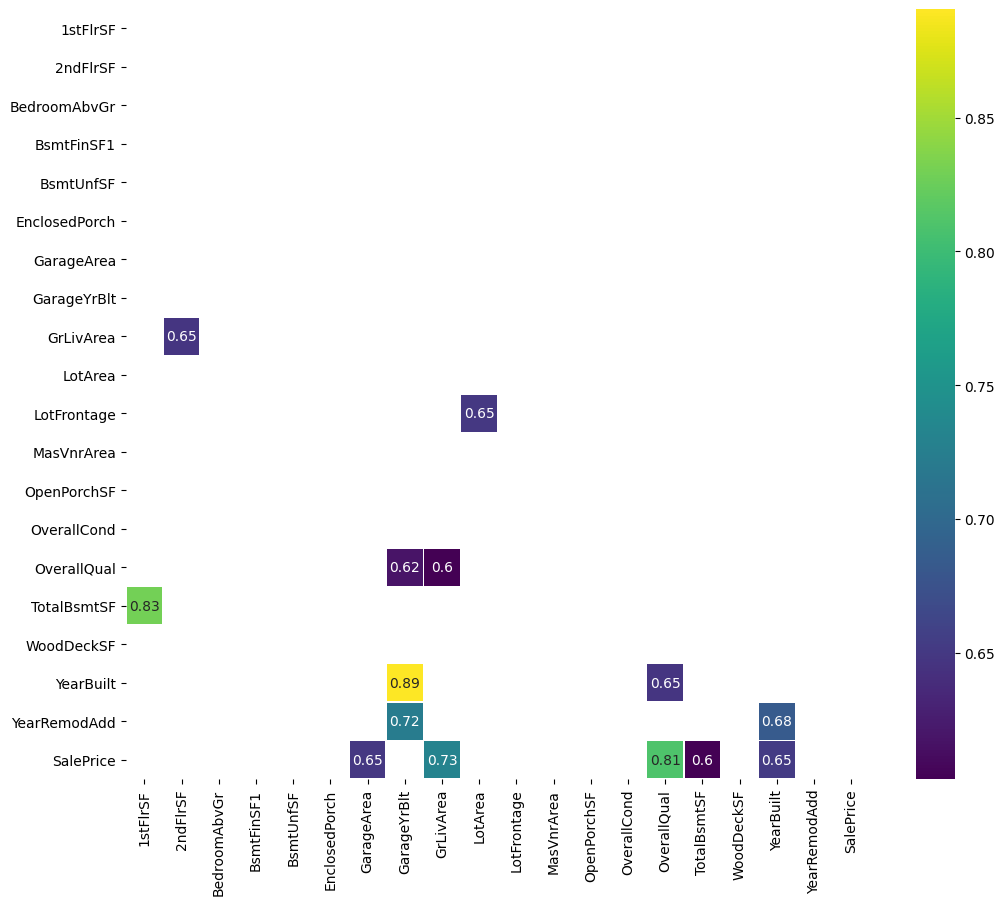



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



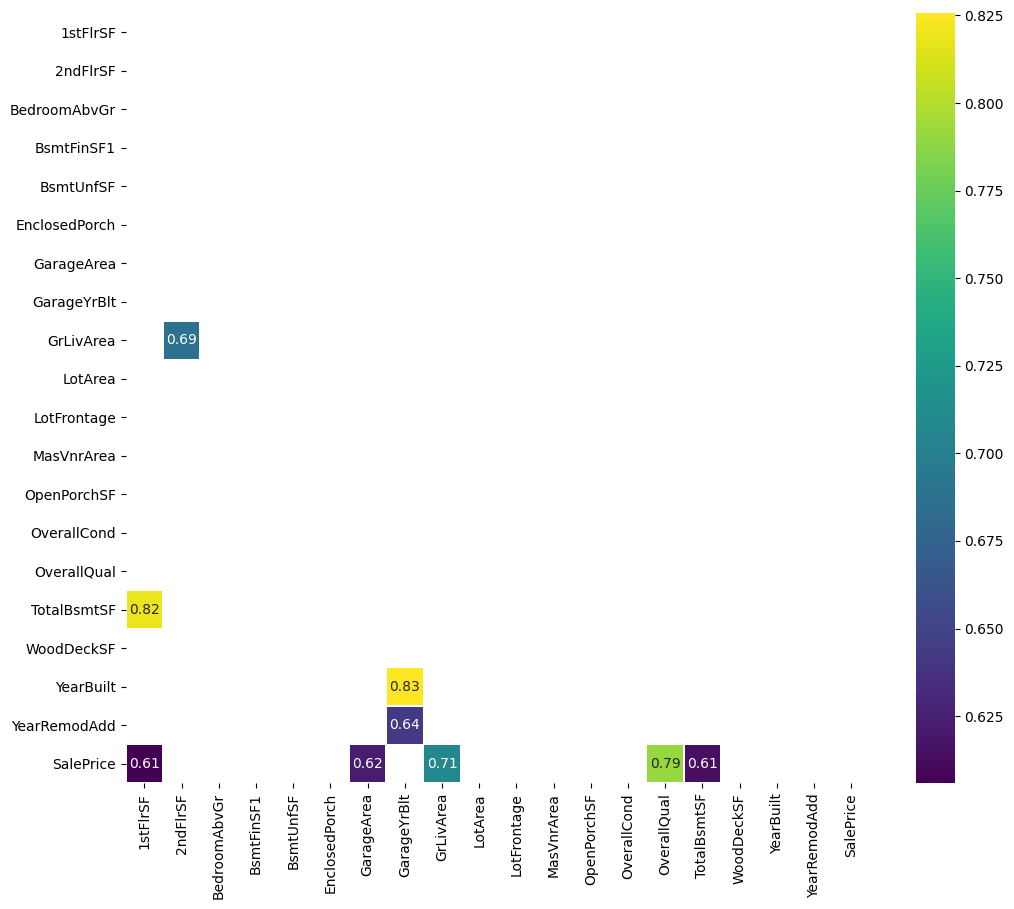



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



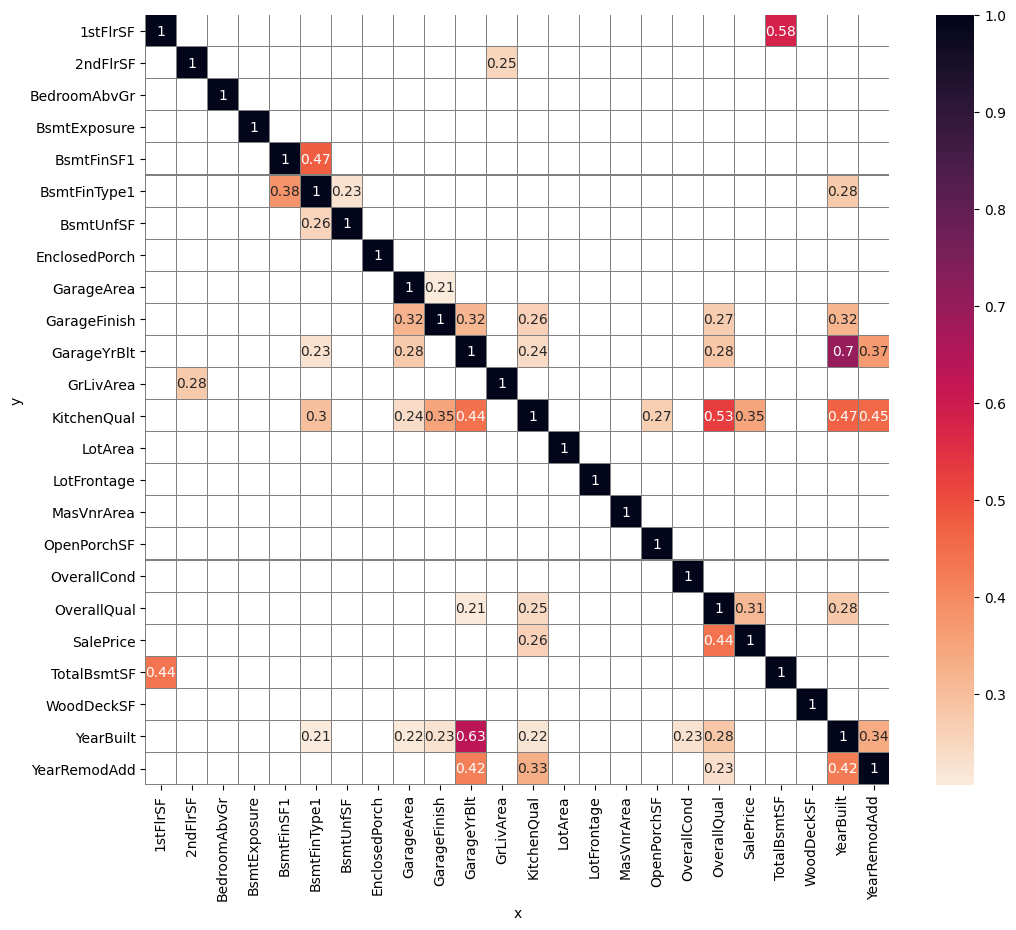

In [11]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.6, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot=10)

___

## Dataset Analysis

### Data Exploration:

- The data presented in these reports shows that there are fields that contain many zero values, more concerning though, is the number of variables that do not contain data. ie. contain null values. 

    - I will further examine these variables and explore whether there is a common criteria that may assist in imputing data into these variables or whether in some case it is viable to drop the feature completely. 
    - I will then do a correlation study and compare the before and after results to establish whether this excise makes a difference to predicting sale price. 


### Correlation and PPS Analysis.

- We should have in mind that the results show a number of variables to be moderated to strong predictors for other variables, most 
asynchronously. However, I am highly interested in variables that are predictors of the sale price.

    - From the results of both the correlation and PPS studies, I see that the strongest predictor of sale price (SalePrice) is Overall Quality (OverallQual) of the property. 
    - Overall the correlation study shows 6 features that are positively and strongly correlated to SalePrice:
        - 1stFlorSF (first floor square foot)
        - GarageArea (garage area measured in square foot)
        - GrLivArea (ground floor living area)
        - OverallQual (Overall quality of materials used)
        - TotalBsmtSF (The total of basement measured in sq. ft.)
        - YearBuilt (The year when the house was built)


DataCleaningEffect() taken from ML Feature Engine Unit 9: Custom Functions.

-  Function objective: assess the effect of the cleaning data when:
    - input mean, median aor arbitrary number is a numerical variable.
    - Replace with 'Missing' or most frequent a categorical variable.
- Parameters: 
    - df_original: data not being cleaned. 
    - df_cleaned: data being cleaned.
    - variables_applied_with_method: variables where i have applied a given method.


- It is understandable if, at first, the below code seems a little complicated, at this point we try to make sense of the pseud-code and understand the function parameters.  

In [12]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate the plot number
  
  # Distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over the variables, 
    # first on variables that you applied to the method
    # if the variable is numerical plot a histogram, if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1


___

## Data Cleaning

### Assessing the missing data levels from our dataset.

- We need to custom the function so this can show us the missing data levels in a data frame. 
    - Absolute levels.
    - Relative levels
    - Data type.

In [13]:
def EvaluateMissingData(df):
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage,
                                 "DataType":df.dtypes}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

- We have to evaluate the missing data:

In [14]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


- After the evaluation we can see the variables listed with the missing data.
- Therefore we will drop the Enclosed Porch and WoodDeckSF as there are more then 89.38, respectively 90.68 percent of null values.
- Other fields may possibly be imputed with a valid value or median.

*As we can see the 6 features that show positively and strongly correlation to the sale price of each house are not listed among these variables that contain null values.*

The 6 features that show positively correlation to the sale price are:
    - 1stFlrSF,
    - GarageArea,
    - GrLivArea,
    - OverallQuall,
    - TotalBsmtSF,
    - YearBuilt.

**At this point it is important to have a copy of the house price records data frame:**

In [15]:
df_clean = df.copy()
print(df_clean.shape)

(1460, 24)


___

## Train and Test

- It is very important to split the dataset in 2 parts, so we will be able to test and train the ML.
    - It is also very important to split those in almost equal parts so we won't end up with not having enough data to train or test.

In [16]:
from sklearn.model_selection import train_test_split
train_set, test_set, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"train_set shape: {train_set.shape} \ntest_set shape: {test_set.shape}")

train_set shape: (1168, 24) 
test_set shape: (292, 24)


After we have split the dataset in the train set (1168, 24) and test_set (292, 24), we have to evaluate the missing values from train_set.

In [17]:
df_missing_data = EvaluateMissingData(train_set)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


- After the evaluation from train_set, looks like there are 9 variables in total with missing data.
- Therefore, we will further investigate the 2 with a higher percentage of missing data.
    - EnclosedPorch (90.41%)
    - WoodDeckSF (88.53%)

In [18]:
df_wooddecksf = train_set.loc[train_set['WoodDeckSF'].notnull()]
df_wooddecksf[['WoodDeckSF', 'SalePrice']]

,WoodDeckSF,SalePrice
40,0.0,160000
703,344.0,140000
1331,0.0,132500
546,0.0,210000
638,328.0,85000
...,...,...
1419,0.0,223000
802,36.0,189000
544,100.0,179665
697,0.0,123500


In [19]:
df_wooddecksf['WoodDeckSF'].value_counts().sort_index(ascending=False).head(10)

736.0    1
550.0    1
466.0    1
431.0    1
416.0    1
382.0    1
364.0    1
356.0    1
355.0    1
351.0    1
Name: WoodDeckSF, dtype: int64

### EnclosedPorch - Enclosed porch area in square feet.

- During the evaluation of the missing data, we can clearly see that this variable contains more them 90% null values. (90.41%).
- According with the evaluation, we consider that this element won't be adding any value to the sale price.
- As the houses that my niece plans to buy do not have an enclosed porch I consider this element to be with no power of predictive sale price.

### WoodDeckSF - Wood deck area in square feet.

- During the evaluation of the missing data, we can clearly see that this variable contains more then 88% null values. (88.53%).
- According with the evaluation, we consider that this element won't be adding any value to the sale price.
- As the houses that my niece plans to buy do not add enough uniques to the houses, also the houses have to be refurbished before sale. 


Furthermore, I consider that the correlation and PPS analysis shows that these fields have no predictive power.

### Conclusion

Having in mind the above mentioned factors we consider that EnclosedPorch and WoodDeckSF add no value to the sale price, therefore we will be dropping this 2 factors.

- In order to drop these 2 factors we will be using the 'feature_engine's DropFeatures' method. 

In [20]:
from feature_engine.selection import DropFeatures
variables = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables)
imputer.fit(train_set)
train_set, test_set = imputer.transform(train_set), imputer.transform(test_set)
train_set.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,NaN,Av,48,NaN,1774,774,Unf,2007.0,1828,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
870,894,0.0,2.0,No,0,Unf,894,308,NaN,1962.0,894,TA,6600,60.0,0.0,0,5,5,894,1962,1962,109500
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,964,TA,13360,80.0,0.0,0,7,5,876,1921,2006,163500
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,1689,Gd,13265,NaN,148.0,59,5,8,1568,2002,2002,271000
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,1541,Gd,13704,118.0,150.0,81,5,7,1541,2001,2002,205000


We will clean the dataset for the refurbished houses as well.

In [21]:
df_clean = imputer.transform(df_clean)

In [22]:
null_variables = train_set.columns[train_set.isnull().any()].tolist()

___

## Variables to consider transforming or imputing.

- Inspect the LotFrontage and MasVnrArea variables.

- LotFrontage:

In [23]:
train_set['LotFrontage'].value_counts().sort_index(ascending=False).head(10)

313.0    1
182.0    1
174.0    1
168.0    1
153.0    1
150.0    1
149.0    1
144.0    1
141.0    1
140.0    1
Name: LotFrontage, dtype: int64

- MasVnrArea:

In [24]:
train_set['MasVnrArea'].value_counts().sort_index(ascending=False).head(10)

1600.0    1
1378.0    1
1170.0    1
1129.0    1
1115.0    1
1047.0    1
975.0     1
894.0     1
870.0     1
860.0     1
Name: MasVnrArea, dtype: int64

- The PPS score on the above variables (LotFrontage and MasVnrArea), shows that these fields have no predictive power.
- The correlation study shows they have a moderate correlation to the sale price.
- On inspecting the dataset, for these variables, it is noted that in relation to other variables there is no way of identifying or deriving possible valid values for imputing on null variables. 

### In conclusion:

- Use MeanMedianImputer to impute a median value into the null variables:


In [25]:
from feature_engine.imputation import MeanMedianImputer
variables = ['LotFrontage', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables)
imputer.fit(train_set)
train_set, test_set = imputer.transform(train_set), imputer.transform(test_set)

In [26]:
df_clean = imputer.transform(df_clean)

In [27]:
EvaluateMissingData(train_set)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64


- We can clearly see that after conducting our investigation and eliminating EnclosedPorch, WoodDeckSF and imputing null variables for LotFrontage and MasVnrArea they are not longer presented on our list.

- Further more, we will investigate the left elements to see their importance in the sale price. 

### 2ndFlrSf - Second floor square feet.

- Inspecting the 2ndFlrSF variable: 

In [28]:
train_set['2ndFlrSF'].value_counts().sort_index()

0.0       626
110.0       1
167.0       1
192.0       1
208.0       1
         ... 
1540.0      1
1611.0      1
1796.0      1
1818.0      1
1872.0      1
Name: 2ndFlrSF, Length: 345, dtype: int64

- As stated above in the evaluating missing data, the 2nd floor square foot has 60 variables of 1168 which contain null variables.
- After a closer look at the dataset, it appears that if there is not a second floor, the value would be set to 0.
    - More then 50% of values for this variable is 0. Therefore, we deduce imputing the null values with 0 would add value to our dataset. 
- We prepare the pipeline to use ArbitraryNumberImputer to input 0 into the null variables. 

### BedroomAbvGr - Bedrooms above grade (dose NOT include basement bedrooms)

- Inspecting the BedroomAbvGr:

In [29]:
train_set['BedroomAbvGr'].value_counts().sort_index()


0.0      4
1.0     32
2.0    266
3.0    599
4.0    166
5.0     16
6.0      4
8.0      1
Name: BedroomAbvGr, dtype: int64

- 80 variables of 1168 contains null values.
- Looking at the values we could see that there are only 4 records in our data set that contain 0 for bedrooms that are not included in basement. 
- As all the proprieties that my niece will refurbish contain values above 0, imputing the null values with 0 will not have an effect on the sales price analysis. 
- Furthermore, we will prepare the pipeline to use ArbitraryNumberImputer to input 0 into the null variables. 

In [30]:
pipeline = Pipeline([( '2ndFlrSF',  ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'BedroomAbvGr']))])
pipeline

Pipeline(steps=[('2ndFlrSF',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF',
                                                   'BedroomAbvGr']))])

In [31]:
pipeline.fit(train_set)
train_set, test_set = pipeline.transform(train_set), pipeline.transform(test_set)

In [32]:
df_clean = pipeline.transform(df_clean)

In [33]:
EvaluateMissingData(train_set)

,RowsWithMissingData,PercentageOfDataset,DataType
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
GarageYrBlt,58,4.97,float64


- After adjusting the pipeline we can see that 2ndFlrSF and BedroomAbvGr no longer appear on our list.

- Now we will investigate the BsmtFinType1.

### BsmtFinType1 - Rating of basement finished area.

- Inspecting BsmtFinType1 variable:

In [34]:
train_set['BsmtFinType1'].value_counts().sort_index()

ALQ     159
BLQ     114
GLQ     303
LwQ      52
None     25
Rec     100
Unf     326
Name: BsmtFinType1, dtype: int64

- Inspect BsmtExposure variable:


In [35]:
train_set['BsmtExposure'].value_counts().sort_index()

Av      174
Gd      106
Mn       92
No      768
None     28
Name: BsmtExposure, dtype: int64

In [36]:

train_set[train_set['BsmtFinType1'].isna()].query('BsmtExposure=="None"').sort_values(by=['BsmtExposure'])


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
90,1040,0.0,2.0,None,0,NaN,0,420,Unf,1950.0,1040,TA,7200,60.0,0.0,29,5,4,0,1950,1950,109900
736,1040,0.0,2.0,None,0,NaN,0,400,Unf,1949.0,1040,TA,8544,60.0,0.0,0,4,3,0,1950,1950,93500
1179,1124,0.0,3.0,None,0,NaN,0,0,None,NaN,1124,TA,8335,77.0,0.0,36,5,5,0,1954,1954,93000


- 89 variables of 1168 contains null values.
- After inspecting the dataset, we will be able to see that there are only 25 properties with no basement.
- BsmtExposure however contains no null variables and on comparing the two fields i established that there are only 3 rows that are set to None.

- For these 3 rows the BsmtFinType1 variable can bee imputed with None.

In [37]:
query_condition = (train_set.BsmtExposure == 'None') & (train_set['BsmtFinType1'].isnull())
train_set['BsmtFinType1'] = np.where(query_condition, 'None', train_set['BsmtFinType1'])

In [38]:
query_condition = (test_set.BsmtExposure == 'None') & (test_set['BsmtFinType1'].isnull())
test_set['BsmtFinType1'] = np.where(query_condition, 'None', test_set['BsmtFinType1'])

In [39]:
query_condition = (df_clean.BsmtExposure == 'None') & (df_clean['BsmtFinType1'].isnull())
df_clean['BsmtFinType1'] = np.where(query_condition, 'None', df_clean['BsmtFinType1'])

In [40]:
train_set[train_set['BsmtFinType1'].isna()].query('BsmtExposure=="None"').sort_values(by=['BsmtExposure'])

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice


- After the 3 rows have been imputed the value None, we are able to see that they are no longer appearing.

In [41]:
train_set['BsmtFinType1'].isna().sum()

86

- We could see that there are still 86 BsmtFinType1 with a value of null.

- Furthermore, we will be inspecting BsmtFinSF1 variable. 

In [42]:
df_temp = train_set[train_set['BsmtFinType1'].isna()].query('BsmtFinSF1==0').sort_values(by=['BsmtFinSF1'])
print(df_temp.shape)
df_temp

(27, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
431,1088,110.0,4.0,No,0,NaN,901,0,NaN,NaN,1198,TA,5586,60.0,0.0,98,7,6,901,1920,1998,79900
1342,1284,885.0,3.0,No,0,NaN,1284,647,RFn,2002.0,2169,Gd,9375,69.0,149.0,87,5,8,1284,2002,2002,228500
584,989,584.0,3.0,No,0,NaN,884,240,Unf,1935.0,1573,Gd,6120,51.0,0.0,0,7,4,884,1935,1995,133000
890,672,252.0,0.0,Mn,0,NaN,672,576,Unf,2003.0,924,TA,8064,60.0,0.0,0,7,5,672,1949,2006,122900
573,774,656.0,3.0,No,0,NaN,384,400,RFn,2000.0,1430,TA,9967,76.0,0.0,0,5,7,384,2000,2000,170000
653,756,713.0,3.0,No,0,NaN,756,216,Unf,1906.0,1469,TA,10320,60.0,0.0,0,7,6,756,1906,1995,135000
248,840,828.0,3.0,No,0,NaN,840,500,RFn,2003.0,1668,Gd,11317,72.0,101.0,68,5,7,840,2003,2003,180000
1219,672,546.0,3.0,No,0,NaN,672,0,None,NaN,1218,TA,1680,21.0,236.0,0,5,6,672,1971,1971,91500
374,847,1081.0,4.0,No,0,NaN,847,434,Fin,2003.0,1928,Gd,8200,65.0,0.0,48,5,7,847,2003,2004,219500
22,1795,0.0,3.0,No,0,NaN,1777,534,RFn,2002.0,1795,Gd,9742,75.0,281.0,159,5,8,1777,2002,2002,230000


- Moving forward, we will be looking at BsmtFinSF1 which contains no null variables.
- I conducted a search and we could see that BsmtFinType1 has nulls and BsmtFinSF1 with value 0. In conclusion there are 0 finished squared feet, which means unfinished. 

- We have founded that there are BsmtFinType1 has 27 Unf, this means that 27 BsmtFinType1 is actually unfinished. 

In [43]:
query_condition = (train_set.BsmtFinSF1 == 0) & (train_set['BsmtFinType1'].isnull())
train_set['BsmtFinType1'] = np.where(query_condition, 'Unf', train_set['BsmtFinType1'])

In [44]:
query_condition = (test_set.BsmtFinSF1 == 0) & (test_set['BsmtFinType1'].isnull())
test_set['BsmtFinType1'] = np.where(query_condition, 'Unf', test_set['BsmtFinType1'])

In [45]:
query_condition = (df_clean.BsmtFinSF1 == 0) & (df_clean['BsmtFinType1'].isnull())
df_clean['BsmtFinType1'] = np.where(query_condition, 'Unf', df_clean['BsmtFinType1'])

In [46]:
train_set[train_set['BsmtFinType1'].isna()].query('BsmtFinSF1==0').sort_values(by=['BsmtFinSF1']).shape

(0, 22)

- The 27 rows have been imputed with Unf, now those are not longer present in our dataset. 

In [47]:
train_set['BsmtFinType1'].isna().sum()

59

- Looks like there are still 59 BsmtFinType1 containing a null variable.
- These remaining null variables will be imputed with Unk which means Unknown. 

In [48]:
imputer = CategoricalImputer(imputation_method='missing',fill_value='Unk',
                             variables='BsmtFinType1')

imputer.fit(train_set)
train_set, test_set, df_clean = imputer.transform(train_set), imputer.transform(test_set), imputer.transform(df_clean)

In [49]:
train_set['BsmtFinType1'].isna().sum()

0

- After imputing the Unk variables, there are no longer null values of BsmtFinType1.

### Garage Finish - Interior finish of the garage

- Inspecting the GarageFinish Variable.

In [50]:
train_set['GarageFinish'].isna().sum()

131

- Looks like there are 131 variables that are null for GarageFinish variable. 

In [51]:
train_set['GarageFinish'].value_counts().sort_index()

Fin     254
None     53
RFn     293
Unf     437
Name: GarageFinish, dtype: int64

In [52]:
train_set.loc[train_set.GarageFinish=="None",'GarageArea'].value_counts()

0    53
Name: GarageArea, dtype: int64

- After imputing GarageFinish=="None", meaning that the GarageFinish has been imputed with value None, the result is 0. There are no longer GarageArea.

In [53]:
train_set.loc[train_set.GarageFinish.isnull(),'GarageArea'].value_counts()

440    5
0      5
308    4
572    3
240    3
      ..
839    1
639    1
471    1
496    1
856    1
Name: GarageArea, Length: 107, dtype: int64

- As the GarageFinish is null we are able to check if GarageArea is 0 and if so we can impute None on GarageFinish.
- Based on the above query, only 5 rows will be affected. 
- For the remaining records we will assume that the garages are unfinished so, we will impute Unf on Garage Finish.

In [54]:
query_condition = (train_set.GarageArea == 0) & (train_set['GarageFinish'].isnull())
train_set['GarageFinish'] = np.where(query_condition, 'None', train_set['GarageFinish'])

In [55]:
query_condition = (test_set.GarageArea == 0) & (test_set['GarageFinish'].isnull())
test_set['GarageFinish'] = np.where(query_condition, 'None', test_set['GarageFinish'])

In [56]:
query_condition = (df_clean.GarageArea == 0) & (df_clean['GarageFinish'].isnull())
df_clean['GarageFinish'] = np.where(query_condition, 'None', df_clean['GarageFinish'])

In [57]:
train_set['GarageFinish'].isna().sum()

126

In [58]:
pipeline = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                  fill_value='Unf',
                                                  variables=['GarageFinish']) )
])
pipeline

Pipeline(steps=[('categorical_imputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish']))])

In [59]:
pipeline.fit(train_set)

train_set, test_set = pipeline.transform(train_set), pipeline.transform(test_set)

In [60]:
df_clean = pipeline.transform(df_clean)

In [61]:
train_set['GarageFinish'].isna().sum()

0

- After imputing the Unf on GarageFinish, we can see that there are no null values for GarageFinish. 

### GarageYrBlt - The year when the garage was built.

- Inspecting the GarageYrBlt variable.

In [62]:
train_set['GarageYrBlt'].isna().sum()

58

- We have got the row count where GarageYrBlt is null, and return the value of GarageFinish.

In [63]:
train_set.loc[train_set.GarageYrBlt.isnull(),'GarageFinish'].value_counts()

None    58
Name: GarageFinish, dtype: int64

In [64]:
train_set[train_set.GarageFinish=='None']

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
431,1088,110.0,4.0,No,0,Unf,901,0,None,NaN,1198,TA,5586,60.0,0.0,98,7,6,901,1920,1998,79900
638,796,0.0,2.0,No,0,Unf,796,0,None,NaN,796,TA,8777,67.0,0.0,0,7,5,796,1910,1950,85000
1337,693,0.0,2.0,No,0,Unf,693,0,None,NaN,693,Fa,4118,153.0,0.0,20,4,4,693,1941,1950,52500
528,605,0.0,2.0,Mn,348,Unk,180,0,None,NaN,605,TA,9098,58.0,0.0,0,7,4,528,1920,2002,86000
960,858,0.0,2.0,Gd,696,BLQ,162,0,None,NaN,858,TA,7207,50.0,0.0,0,7,5,858,1958,2008,116500
1011,1664,0.0,4.0,None,0,None,0,0,None,NaN,1664,TA,9825,75.0,0.0,0,5,5,0,1965,1965,100000
1283,912,912.0,4.0,Av,0,Unf,912,0,None,NaN,1824,TA,9400,94.0,0.0,0,5,6,912,1971,1971,139000
1038,798,546.0,3.0,No,0,Unf,546,0,None,NaN,1344,TA,1533,21.0,0.0,0,6,4,546,1970,2008,97000
165,808,547.0,4.0,No,351,ALQ,112,0,None,NaN,1355,TA,10106,62.0,0.0,0,7,5,644,1940,1999,127500
1349,938,1215.0,4.0,No,259,LwQ,425,0,None,NaN,2358,TA,5250,50.0,0.0,54,5,8,684,1872,1987,122000


- We have to keep in mind that 58 null records are presented for the GarageYrBlt variable.
    - If the GarageYrBlt is null that means that the variable GarageFinish will be automatically none. This means that the property doesn't have a garage. 
- We will prepare the pipeline to use ArbitraryNumberImputer to impute 0 into the null variables:

In [65]:
pipeline = Pipeline([
      ( 'GarageYrBlt',  ArbitraryNumberImputer(arbitrary_number=0,
                                                variables='GarageYrBlt') )
])
pipeline

pipeline.fit(train_set)
train_set, test_set = pipeline.transform(train_set), pipeline.transform(test_set)

In [66]:
df_clean = pipeline.transform(df_clean)

- Now we have to see the missing data evaluation.

In [67]:
EvaluateMissingData(train_set)

,RowsWithMissingData,PercentageOfDataset,DataType


In [68]:
EvaluateMissingData(df_clean)

,RowsWithMissingData,PercentageOfDataset,DataType


- We can breath normally, as there are no longer variables missing data.

___

## Before and after comparison.

We now have to assess the effect on the variables distribution.

- The function plots in the same axes the distribution before and after applying the method.
- Now we will be able to see how different our variables would look after cleaning the data.
- We can notice a peak in the variable distribution after median imputation. 


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'] 




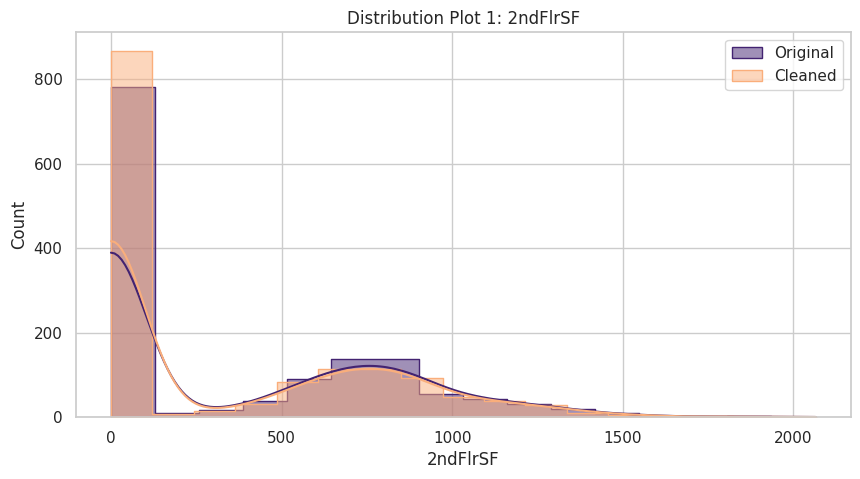

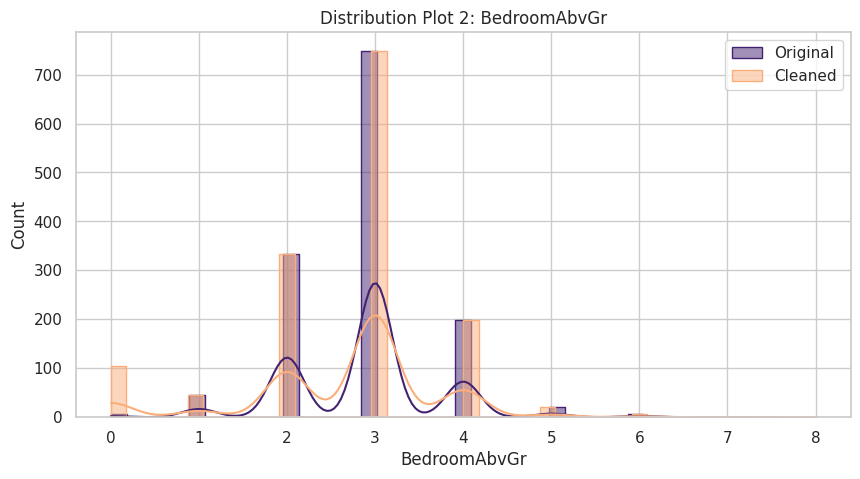

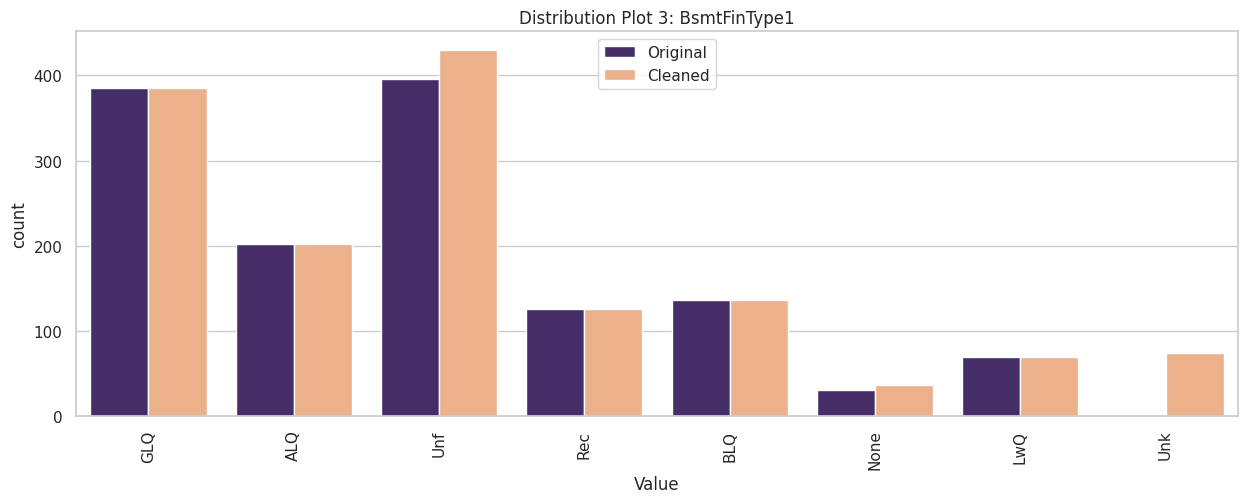

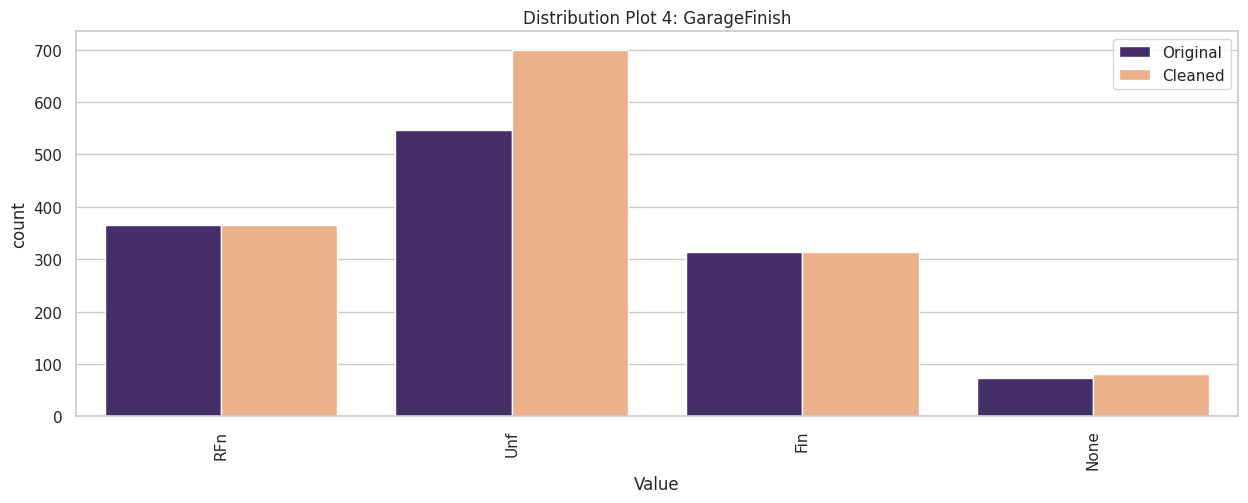

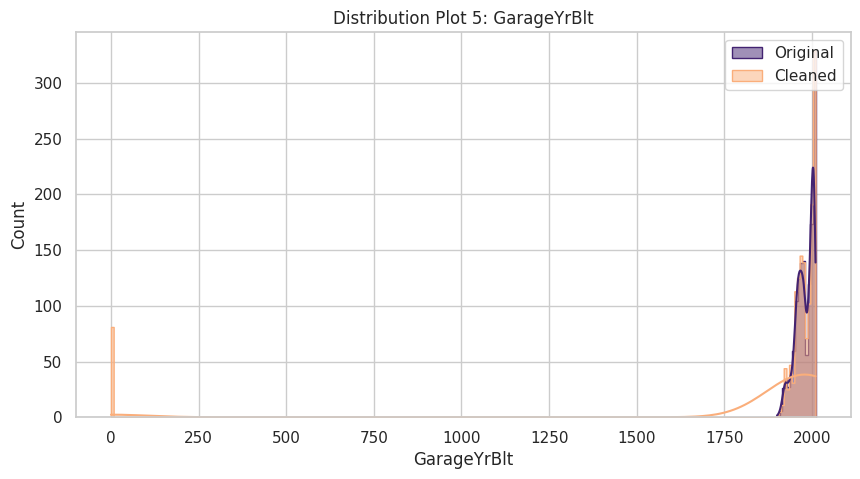

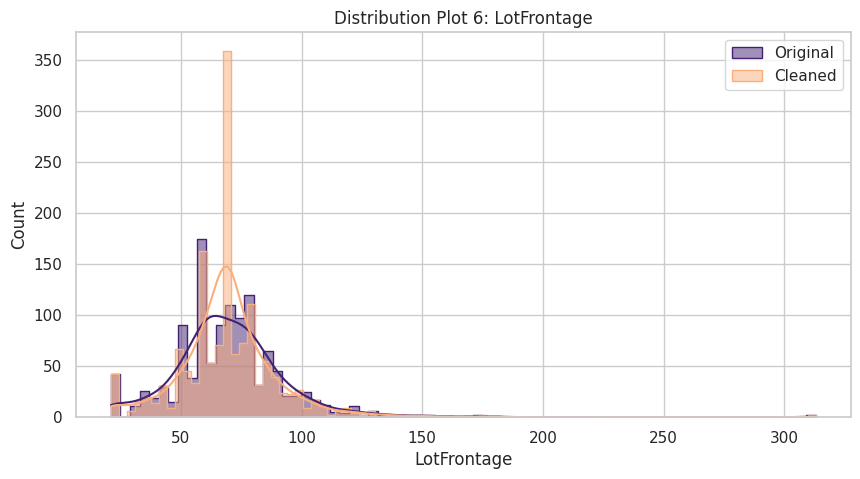

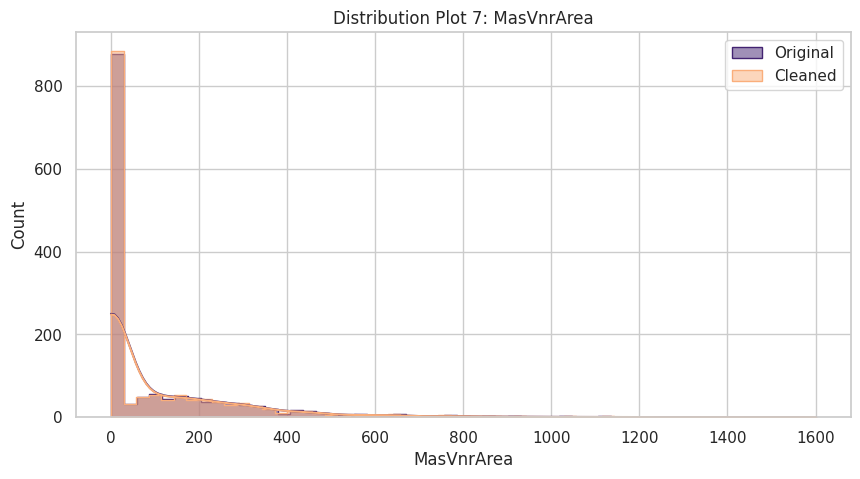

In [69]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_clean,
                   variables_applied_with_method=null_variables)

___

## Datatype changes - Float to integer.

- After examining tha data in the refurbished houses, we will be able to see that there are no float values in the float columns so we will change these into integers. 

In [70]:
print(df_clean.shape)

(1460, 22)


In [71]:
df_clean.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   2ndFlrSF      1460 non-null   float64
 1   BedroomAbvGr  1460 non-null   float64
 2   GarageYrBlt   1460 non-null   float64
 3   LotFrontage   1460 non-null   float64
 4   MasVnrArea    1460 non-null   float64
dtypes: float64(5)
memory usage: 57.2 KB


In [72]:
for col in df_clean.select_dtypes('float').columns:
    df_clean[col] = df_clean[col].astype('int64')

In [73]:
df_clean.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Empty DataFrame

On examining the data in the refurbished houses, we can see that there are no float values. So we will change these into int.

In [75]:
for col in df_refurbished.select_dtypes('float').columns:
    df_refurbished[col] = df_refurbished[col].astype('Int64')

In [76]:
df_refurbished.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Empty DataFrame

In [77]:
df_refurbished.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   1stFlrSF       6 non-null      int64 
 1   2ndFlrSF       6 non-null      int64 
 2   BedroomAbvGr   6 non-null      int64 
 3   BsmtExposure   6 non-null      object
 4   BsmtFinSF1     6 non-null      int64 
 5   BsmtFinType1   6 non-null      object
 6   BsmtUnfSF      6 non-null      int64 
 7   EnclosedPorch  6 non-null      int64 
 8   GarageArea     6 non-null      int64 
 9   GarageFinish   6 non-null      object
 10  GarageYrBlt    6 non-null      int64 
 11  GrLivArea      6 non-null      int64 
 12  KitchenQual    6 non-null      object
 13  LotArea        6 non-null      int64 
 14  LotFrontage    6 non-null      int64 
 15  MasVnrArea     6 non-null      int64 
 16  OpenPorchSF    6 non-null      int64 
 17  OverallCond    6 non-null      int64 
 18  OverallQual    6 non-null      int

___

Change float columns to int for train and test.

In [78]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1168 non-null   int64  
 1   2ndFlrSF      1168 non-null   float64
 2   BedroomAbvGr  1168 non-null   float64
 3   BsmtExposure  1168 non-null   object 
 4   BsmtFinSF1    1168 non-null   int64  
 5   BsmtFinType1  1168 non-null   object 
 6   BsmtUnfSF     1168 non-null   int64  
 7   GarageArea    1168 non-null   int64  
 8   GarageFinish  1168 non-null   object 
 9   GarageYrBlt   1168 non-null   float64
 10  GrLivArea     1168 non-null   int64  
 11  KitchenQual   1168 non-null   object 
 12  LotArea       1168 non-null   int64  
 13  LotFrontage   1168 non-null   float64
 14  MasVnrArea    1168 non-null   float64
 15  OpenPorchSF   1168 non-null   int64  
 16  OverallCond   1168 non-null   int64  
 17  OverallQual   1168 non-null   int64  
 18  TotalBsmtSF   1168 non-null

In [79]:
for col in train_set.select_dtypes('float').columns:
    train_set[col] = train_set[col].astype('int64')

In [80]:
for col in test_set.select_dtypes('float').columns:
    test_set[col] = test_set[col].astype('int64')

___

## Save the training and test sets to csv.

- Create a cleaned folder:

In [82]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

- output the clean datasets to csv files into the outputs/datasets folder
- outputs/datasets/cleaned/train_set.csv
- outputs/datasets/cleaned/test_set.csv
- outputs/datasets/cleaned/clean_house_price_records.csv

In [ ]:
train_set.to_csv("outputs/datasets/cleaned/train_set.csv", index=False)

In [ ]:
test_set.to_csv("outputs/datasets/cleaned/test_set.csv", index=False)

In [ ]:
df_clean.to_csv("outputs/datasets/cleaned/clean_house_price_records.csv", index=False)

In [ ]:
df_refurbished.to_csv("outputs/datasets/cleaned/clean_refurbished_houses.csv", index=False)

___

## Conclusion and Next Steps

- We have created a cleaning version of the housing price dataset and the refurbished houses datasets.
- On the refurbished dataset the only step taken was to drop the variables EnclosedPorch and WoodDeckSf.
- The housing price were saved to csv files in the outputs/datasets/cleaned folder:
    - clean_house_price_records.csv
    - clean_refurbished_houses.csv
    - train_set.csv
    - test_set.csv

- Further, we will be moving on to Feature Engineering.

___